In [1]:
# Forecast the daily closing price of GOOGL

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/GOOGL.csv')

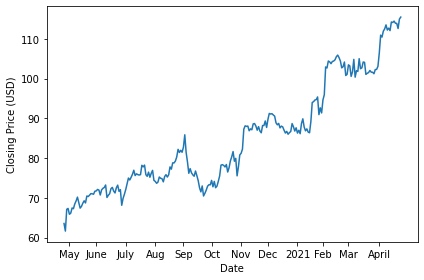

In [4]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')

plt.xticks(
            [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
           ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 2021, 'Feb', 'Mar', 'April']
    )

#fig.autofmt_xdate()

plt.tight_layout()

In [5]:
# Test for stationarity - use augmented Dickey-Fuller (ADF) test
# If the test returns a p-value less than a certain significance level, typically 0.05 or 0.01, the series is stationary.

from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['Close'])

print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")

ADF Statistic: 0.31837760615546457
P-value: 0.9781721063148977


In [6]:
# Apply a first-order difference.

diff_close = np.diff(df['Close'], n=1)

In [7]:
# Test for stationarity - use augmented Dickey-Fuller (ADF) test

diff_adf_result = adfuller(diff_close)

print(f"ADF Statistic: {diff_adf_result[0]}")
print(f"P-value: {diff_adf_result[1]}")

ADF Statistic: -5.263208852421107
P-value: 6.522974284131761e-06


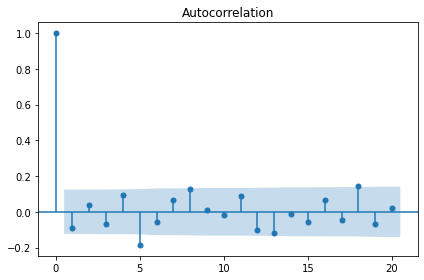

In [8]:
# Check for auto - correlation: measures the correlation between a variable and itself at a previous timestep (lag)
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(diff_close, lags=20)

plt.tight_layout()

In [9]:
# Split GOOGL random walk into a train set containing the total entries minus 5.
# The remaining 5 days will be your test set.

total_set = df.shape[0]
test_nos = 5
train_nos = total_set - test_nos

train = df[:train_nos].copy()
test = df[train_nos:].copy()

In [10]:
# Forecast the last 5 days of the closing price using naive forecasting methods 
# 1. Forecasting the mean

mean = np.mean(train.Close)

test.loc[:, 'pred_mean'] = mean
test.head(6)

,Date,Open,High,Low,Close,Adj Close,Volume,pred_mean
247,2021-04-20,114.874496,114.949997,112.856003,113.950500,113.950500,22288000,84.380425
248,2021-04-21,113.602501,114.000000,112.240997,113.917503,113.917503,23204000,84.380425
249,2021-04-22,113.769997,114.444000,112.015999,112.625999,112.625999,24146000,84.380425
250,2021-04-23,113.349998,115.306000,113.062500,114.996498,114.996498,29066000,84.380425
251,2021-04-26,115.225998,116.226501,114.865997,115.496498,115.496498,32038000,84.380425


In [11]:
# 2. Forecasting the last value

last_value = train.iloc[-1].Close

test.loc[:, 'pred_last'] = last_value
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,pred_mean,pred_last
247,2021-04-20,114.874496,114.949997,112.856003,113.950500,113.950500,22288000,84.380425,114.487999
248,2021-04-21,113.602501,114.000000,112.240997,113.917503,113.917503,23204000,84.380425,114.487999
249,2021-04-22,113.769997,114.444000,112.015999,112.625999,112.625999,24146000,84.380425,114.487999
250,2021-04-23,113.349998,115.306000,113.062500,114.996498,114.996498,29066000,84.380425,114.487999
251,2021-04-26,115.225998,116.226501,114.865997,115.496498,115.496498,32038000,84.380425,114.487999


In [12]:
# 3. Drift method
# Slope of a straight line by dividing the change in the y-axis by the change in the x-axis

deltaX = train_nos - 1
deltaY = last_value - 0

drift = deltaY / deltaX
#print(drift)
x_vals = np.arange(train_nos, total_set, 1)

pred_drift = drift * x_vals

test.loc[:, 'pred_drift'] = pred_drift
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,pred_mean,pred_last,pred_drift
247,2021-04-20,114.874496,114.949997,112.856003,113.950500,113.950500,22288000,84.380425,114.487999,114.953397
248,2021-04-21,113.602501,114.000000,112.240997,113.917503,113.917503,23204000,84.380425,114.487999,115.418796
249,2021-04-22,113.769997,114.444000,112.015999,112.625999,112.625999,24146000,84.380425,114.487999,115.884194
250,2021-04-23,113.349998,115.306000,113.062500,114.996498,114.996498,29066000,84.380425,114.487999,116.349592
251,2021-04-26,115.225998,116.226501,114.865997,115.496498,115.496498,32038000,84.380425,114.487999,116.814991


In [13]:
# measure the MSE for the different naive forecasting methods
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['Close'], test['pred_mean'])
mse_last = mean_squared_error(test['Close'], test['pred_last'])
mse_drift = mean_squared_error(test['Close'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

890.0389389997663 1.0714112654038075 3.4889612927745226


<BarContainer object of 3 artists>

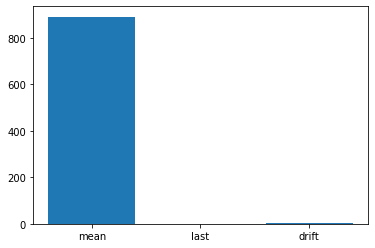

In [14]:
plt.bar(['mean', 'last', 'drift'], [mse_mean, mse_last, mse_drift])

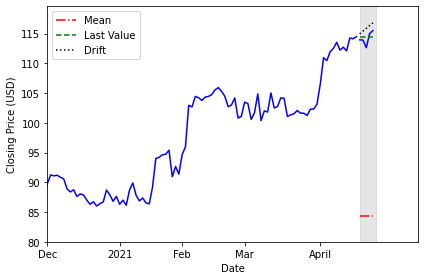

In [15]:
fig, ax = plt.subplots()

ax.plot(train.Date, train.Close, 'b-')
ax.plot(test['Close'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label="Mean")
ax.plot(test['pred_last'], 'g--', label="Last Value")
ax.plot(test['pred_drift'], 'k:', label="Drift")

ax.axvspan(train_nos, total_set, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')


plt.xticks(
            [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
           ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 2021, 'Feb', 'Mar', 'April']
    )

ax.set_xlim(152,)
ax.set_ylim(80,)

plt.tight_layout()

In [16]:
# 4. Forecasting the next timestep
df_shift = df['Close'].shift(periods = 1)

df_shift.head()

0          NaN
1    63.542999
2    61.629501
3    67.109001
4    67.334999
Name: Close, dtype: float64

In [17]:
mse_one_step = mean_squared_error(test['Close'], df_shift[train_nos:])
print(mse_one_step)

1.56544841360541


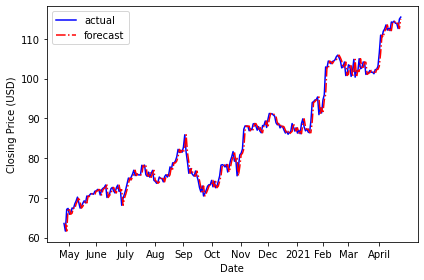

In [18]:
fig, ax = plt.subplots()


ax.plot(df['Date'], df['Close'], 'b-', label='actual')
ax.plot(df_shift, 'r-.', label="forecast")

ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')

plt.xticks(
            [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
           ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 2021, 'Feb', 'Mar', 'April']
    )

plt.tight_layout()

In [19]:
# Record end time

end = dt.now()
elapsed = end - start

print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:00:10
